<a href="https://colab.research.google.com/github/neurorishika/PSST/blob/master/Tutorial/Day%203%20Cells%20in%20Silicon/Day%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neurorishika/PSST/master/Tutorial/Day%203%20Cells%20in%20Silicon/Day%203.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

## Day 3: Cells in Silicon

Welcome to Day 3! Today, we start with our discussion of Hodgkin Huxley Neurons and how we can simulate them in Python using Tensorflow and Numerical Integration.

The electric potential measured across the membranes of excitable cells, such as neurons or heart cells, can undergo transient changes when perturbed by external inputs. When the inputs to a neuron are sufficiently large these transient changes can regeneratively build up into a large deviation from the resting state known as an action potential. Action potentials propagate undiminished along the axon and perturb post-synaptic neurons. The Hodgkin-Huxley model is a system of differential equations that describe the generation an action potential and its propagation along the axon. We provide only a brief overview of the Hodgkin-Huxley model. A number of classic references (Dayan 2005, Johnston 1995) and the original papers by Hodgkin and Huxley (Huxley 1952) chronicle the history and the details of the model. An excellent set of MOOCS and the accompanying textbooks (Gerstner 2014, Dayan 2005) give an accessible introduction to the topic

### What is the Hodgkin Huxley Neuron Model? 

The cell membrane, a 5nm thick lipid bilayer, separates the inside from the outside of the neuron. The membrane is largely impermeable to charged ions present on either side. The concentration of $\text{Na}^{+}$ ions outside the cell is greater than its concentration inside, while $\text{K}^{+}$ ions are relatively abundant inside compared to the outside. In addition to these there are chloride ($\text{Cl}^{-}$), calcium ($\text{Ca}^{2+}$) and magnesium ions ($\text{Mg}^{+}$) that populate the cellular milieu. The differences in ionic abundances across the membrane cause a net accumulation of positive ions on one side of the membrane and negative ions on the other, and thus a potential difference across the membrane. Embedded on the membrane are ion channels that are highly selective to the ion species it lets across. In the squid axon, Hodgkin and Huxley found that there were only two types of ion channels ($\text{Na}^{+}$ and $\text{K}^{+}$), in addition to a non-specific leak channel. The Hodgkin-Huxley model of neurons can be understood with the help of an equivalent electrical circuit given below. The cell membrane acts as a capacitor. The total injected current ($I$) can be written as the sum of the capacitive current $I_{C}$, ionic currents $I_{Na}$ and $I_{K}$ and the leak current $I_L$.


<img src="https://raw.githubusercontent.com/neurorishika/PSST/master/Tutorial/Day%203%20Cells%20in%20Silicon/circuit.svg" width="800"/>

$$ I = I_{C}(t) + I_{Na}(t) + I_{K}(t)$$
where, 
$$C_m = 1 \mu F/cm^2$$
$$I_{Na} = g_{Na}(u-E_{Na})$$
$$I_{K} = g_{k}(u-E_K)$$
$$I_{L} = g_{L}(u-E_L)$$

The equation describing the membrane potential can thus be written as follows,

$$C_m\frac{dV}{dt}=−I_{Na}(t)−I_{K}(t)−I_{L}(t)+I(t)$$

Hodgkin and Huxley discovered that the $Na$ and the $K$ channels do not act as Ohmic conductances, but are modulated by the potential across the membrane. 
Changes in potential had a nonlinear effect on flow of ionic currents. Based in their experimental results they obtained a system of differential equations that described the temporal evolution of the membrane potential in terms of changes in ionic currents (chiefly $\text{Na}^{+}$ and $\text{K}^{+}$). 

$$I = g_{Na}m^3h(u−E_{Na})$$
$$I_K = g_Kn^4(u−E_K)$$
$$I_L = g_L(u−E_L)$$

where $E_{Na}=50\ mV$, $E_K = -95\ mV$ and $E_L=-55\ mV$ are the reversal potentials; $g_{Na} = 100\ \mu S/cm^2$, $g_K = 10\ \mu S/cm^2$ and $g_L = 0.15\ \mu S/cm^2$ are the channel conductances; and m,h, and n are gating variables that follow the dynamics given by:

$$\frac{dm}{dt} = - \frac{1}{\tau_m}(m-m_0) $$
$$\frac{dh}{dt} = - \frac{1}{\tau_h}(h-h_0)$$
$$\frac{dn}{dt} = - \frac{1}{\tau_n}(n-n_0)$$

where $\tau_m$, $\tau_h$ and $\tau_n$ are empirically determined voltage dependent time constants and $m_0$, $h_0$ and $n_0$ are voltage dependent asymptotic gating values.


<img src="https://raw.githubusercontent.com/neurorishika/PSST/master/Tutorial/Day%203%20Cells%20in%20Silicon/mhn.svg" width="800"/>

On day 2, we had created a RK4 based numerical integrator. Recall this implementation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

%matplotlib inline


def tf_check_type(t, y0): # Ensure Input is Correct
    """
    This function checks the type of the input to ensure that it is a floating point number.
    """
    if not (y0.dtype.is_floating and t.dtype.is_floating):
        raise TypeError('Error: y0 and t must be floating point numbers.')

class _Tf_Integrator():
    """
    This class implements the Runge-Kutta 4th order method in TensorFlow.
    """
    def integrate(self, func, y0, t):
        """
        This function integrates a function func using the Runge-Kutta 4th order method in TensorFlow.

        Parameters:
        -----------
        func: function
            The function to be integrated.
        y0: float
            The initial condition.
        t: numpy array
            The time array.
        """
        time_delta_grid = t[1:] - t[:-1] # define the time step at each point
        
        def scan_func(y, t_dt): # define the scan function that performs the integration step
            """
            This function performs the integration step.
            
            Parameters:
            -----------
            y: float
                The value of y at which the function is being evaluated.
            t_dt: (float, float)
                The time point and time step at which the function is being evaluated.
            """
            t, dt = t_dt # unpack the time point and time step
            dy = self._step_func(func,t,dt,y) # Make code more modular.
            return y + dy

        y = tf.scan(scan_func, (t[:-1], time_delta_grid),y0)
        return tf.concat([[y0], y], axis=0)
    
    def _step_func(self, func, t, dt, y):
        """
        This function determines the value of the integration step.

        Parameters:
        -----------
        func: function
            The function to be integrated.
        t: float
            The time point at which the function is being evaluated.
        dt: float
            The time step at which the function is being integrated.
        y: float
            The value of y at which the function is being evaluated.
        """
        k1 = func(y, t)
        half_step = t + dt / 2
        dt_cast = tf.cast(dt, y.dtype) # Failsafe

        k2 = func(y + dt_cast * k1 / 2, half_step)
        k3 = func(y + dt_cast * k2 / 2, half_step)
        k4 = func(y + dt_cast * k3, t + dt)
        return tf.add_n([k1, 2 * k2, 2 * k3, k4]) * (dt_cast / 6) # add all update terms
    
def odeint(func, y0, t):
    """
    This function integrates the function func using the Runge-Kutta 4th order method implemented in the _Tf_Integrator class.

    Parameters:
    -----------
    func: function
        The function to be integrated.
    y0: float
        The initial condition.
    t: numpy array
        The time array.
    """
    # Ensure Input is in the form of TensorFlow Tensors
    t = tf.convert_to_tensor(t, name='t')
    y0 = tf.convert_to_tensor(y0, name='y0')
    tf_check_type(y0,t) # Ensure Input is of the correct type
    return _Tf_Integrator().integrate(func,y0,t)

#### Implementing the Hodgkin-Huxley neuron model

The variables of the Hodgkin Huxley neuron model that are updated at each integration time step are, the membrane potential, $V$, the sodium activation gating variable, $m$, the sodium inactivation gating variable, $h$, and the potassium channel gating variable, $n$. The dynamics are given by Equations above. In the following code, we define the parameters associated with the conductances, including the formulae for $\tau_{m}$, $\tau_{h}$, $\tau_{n}$ and the voltage dependent steady state values of the gating variables. 

##### Step 1: Defining Parameters of the Neuron 

In [2]:
C_m = 1     # Membrane Capacitance

g_K = 10    # K-channel Conductance
E_K = -95   # K-channel Reversal Potential

g_Na = 100  # Na-channel Conductance
E_Na = 50   # Na-channel Reversal Potential

g_L = 0.15  # Leak Conductance
E_L = -55   # Leak Reversal Potential

##### Step 2: Defining functions that calculate $\tau_m$, $\tau_h$, $\tau_n$, $m_0$, $h_0$, $n_0$ 

Note: Always use Tensorflow functions for all mathematical operations.

For our Hodgkin Huxley Model, we will determine the values of $\tau_m$, $\tau_h$, $\tau_n$, $m_0$, $h_0$, $n_0$  by the following equations:

<img src="https://raw.githubusercontent.com/neurorishika/PSST/master/Tutorial/Day%203%20Cells%20in%20Silicon/eqn1.svg" width="800"/>

In [3]:
def K_prop(V):
    """
    This function determines the K-channel gating dynamics.

    Parameters:
    -----------
    V: float
        The membrane potential.
    """
    T = 22 # Temperature
    phi = 3.0**((T-36.0)/10) # Temperature-correction factor
    V_ = V-(-50) # Voltage baseline shift
    
    alpha_n = 0.02*(15.0 - V_)/(tf.exp((15.0 - V_)/5.0) - 1.0) # Alpha for the K-channel gating variable n
    beta_n = 0.5*tf.exp((10.0 - V_)/40.0) # Beta for the K-channel gating variable n
    
    t_n = 1.0/((alpha_n+beta_n)*phi) # Time constant for the K-channel gating variable n
    n_0 = alpha_n/(alpha_n+beta_n) # Steady-state value for the K-channel gating variable n
    
    return n_0, t_n


def Na_prop(V):
    """
    This function determines the Na-channel gating dynamics.
    
    Parameters:
    -----------
    V: float
        The membrane potential.
    """
    T = 22 # Temperature 
    phi = 3.0**((T-36)/10)  # Temperature-correction factor
    V_ = V-(-50) # Voltage baseline shift
    
    alpha_m = 0.32*(13.0 - V_)/(tf.exp((13.0 - V_)/4.0) - 1.0) # Alpha for the Na-channel gating variable m
    beta_m = 0.28*(V_ - 40.0)/(tf.exp((V_ - 40.0)/5.0) - 1.0) # Beta for the Na-channel gating variable m
    
    alpha_h = 0.128*tf.exp((17.0 - V_)/18.0) # Alpha for the Na-channel gating variable h
    beta_h = 4.0/(tf.exp((40.0 - V_)/5.0) + 1.0) # Beta for the Na-channel gating variable h
    
    t_m = 1.0/((alpha_m+beta_m)*phi) # Time constant for the Na-channel gating variable m
    t_h = 1.0/((alpha_h+beta_h)*phi) # Time constant for the Na-channel gating variable h
    
    m_0 = alpha_m/(alpha_m+beta_m) # Steady-state value for the Na-channel gating variable m
    h_0 = alpha_h/(alpha_h+beta_h) # Steady-state value for the Na-channel gating variable h
    
    return m_0, t_m, h_0, t_h

##### Step 3: Defining function that calculate Neuronal currents

<img src="https://raw.githubusercontent.com/neurorishika/PSST/master/Tutorial/Day%203%20Cells%20in%20Silicon/eqn2.svg" width="800"/>

In [4]:
def I_K(V, n):
    """
    This function determines the K-channel current.

    Parameters:
    -----------
    V: float
        The membrane potential.
    n: float 
        The K-channel gating variable n.
    """
    return g_K  * n**4 * (V - E_K)

def I_Na(V, m, h):
    """
    This function determines the Na-channel current.
    
    Parameters:
    -----------
    V: float
        The membrane potential.
    m: float
        The Na-channel gating variable m.
    h: float
        The Na-channel gating variable h.
    """
    return g_Na * m**3 * h * (V - E_Na)

def I_L(V):
    """
    This function determines the leak current.

    Parameters:
    -----------
    V: float
        The membrane potential.
    """
    return g_L * (V - E_L)

##### Step 4: Define the function dX/dt where X is the State Vector

In [5]:
def dXdt(X, t):
    """
    This function determines the derivatives of the membrane voltage and gating variables for a single neuron.

    Parameters:
    -----------
    X: float
        The state vector given by the [V, n, m, h] where V is the membrane potential, n is the K-channel gating variable, m and h are the Na-channel gating variables.
    t: float
        The time points at which the derivatives are being evaluated.
    """
    V = X[0:1] # The first element of the state vector is the membrane potential
    m = X[1:2] # The second element of the state vector is the Na-channel gating variable m
    h = X[2:3] # The third element of the state vector is the Na-channel gating variable h
    n = X[3:4] # The fourth element of the state vector is the K-channel gating variable n

    # Note that here we dont index the elements directly because we want the values as a tensor rather than a single value

    dVdt = (5 - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / C_m  # The derivative of the membrane potential
    # Here the current injection I_injected = 5 uA
    
    m0,tm,h0,th = Na_prop(V) # Calculate the dynamics of the Na-channel gating variables
    n0,tn = K_prop(V) # Calculate the dynamics of the K-channel gating variables

    dmdt = - (1.0/tm)*(m-m0) # The derivative of the Na-channel gating variable m
    dhdt = - (1.0/th)*(h-h0) # The derivative of the Na-channel gating variable h
    dndt = - (1.0/tn)*(n-n0) # The derivative of the K-channel gating variable n

    out = tf.concat([dVdt,dmdt,dhdt,dndt],0) # Concatenate the derivatives into a single tensor
    return out

##### Step 5: Define Initial Condition and Integrate

In [6]:
y0 = tf.constant([-71,0,0,0], dtype=tf.float64) # Initial conditions

epsilon = 0.01 # The step size for the numerical integration
t = np.arange(0,200,epsilon) # The time points at which the numerical integration is being performed

state = odeint(dXdt,y0,t) # Solve the differential equation

with tf.Session() as sess:
    state = sess.run(state) # Run the session

##### Step 6: Plot Output

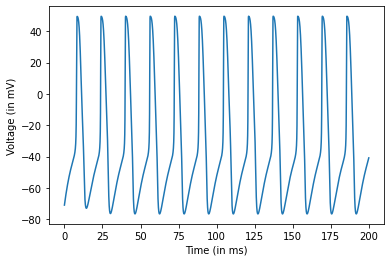

In [7]:
# Plot the membrane potential

plt.plot(t,state.T[0,:])
plt.xlabel("Time (in ms)")
plt.ylabel("Voltage (in mV)")
plt.show()

#### Simulating Multiple Independent HH Neurons at the Same Time

Converting loops into array operations is often termed ‘vectorization’. Array operations are computed by highly optimized functions and are, as a result, nearly an order of magnitude faster to evaluate. The form of the equations that describe the neural dynamics are similar across neurons even though the specific parameters may vary. A large number of such equations may thus be vectorized, eliminating lengthy for loops.

Here we illustrate some simple steps that can be used to simulate populations of neurons efficiently. Key to setting up the equations is to order it in a manner that utilizes TensorFlow's algorithms that distribute vector, matrix and tensor computations over multiple cores. Consider a system of 20 independent HH neurons with different input currents that characterise the firing rates.  

##### Methods of Parallelization
TensorFlow has built-in functions that speed up Tensor computations using available multi-cores, and GPU/TPU setups. There are two major parts of the code where such a speed-up can be effected

1. **RK4 iterations** Our implementation of the integrator utilizes Tensors as inputs. 
2. **Functional Evaluations:** The form of the equations that describe the neuronal dynamics,  are common across neurons. Only the parameters for differ across neurons. This can be used to `vectorize' the equations.

Say $\vec{X}=[V,m,n,h]$ is the state vector of a single neuron and its dynamics are defined using parameters $C_m,g_K,...E_L$ equations of the form: 

$$\frac{d\vec{X}}{dt} = [f_1(\vec{X},C_m,g_K,...E_L),f_2(\vec{X},C_m,g_K,...E_L)...f_m(\vec{X},C_m,g_K,...E_L)]$$

We can convert these equations to a form in which all evaluations are done as vector calculations and NOT scalar calculations. Despite the parameters being different, the functional forms of the equations are similar for the same state variable of different neurons. Thus, the trick is to reorganize $\mathbf{X}$ as $\mathbf{X'}=[(V_1,V_2,...V_n),(m_1,m_2,...m_n),(h_1,h_2,...h_n),(n_1,n_2,...n_n)]=[\vec{V},\vec{m},\vec{h},\vec{n}]$. And the parameters as $[\vec{C_m},\vec{g_K}] = [C_{m_{1}}\dots C_{m_{n}},g_{K_{1}}\dots g_{K_{n}}]$ and so on.

The advantage of this re-ordering is that the differential equation of the form,
$$\frac{dV_i}{dt}=f(V_i,m_i,h_i,n_i,C_{m_i},g_{K_i}...)$$

is now easily parallelizable using a vector computation of the form, 

$$\frac{d\vec{V}}{dt}=f(\vec{V},\vec{m},\vec{h},\vec{n},\vec{C_m},\vec{g_K}...)$$

The equations can now be written in the form,
$$\frac{d\mathbf{X'}}{dt}= \Big[\frac{d\vec{V}}{dt},\frac{d\vec{m}}{dt},\frac{d\vec{h}}{dt},\frac{d\vec{n}}{dt}\Big]$$

In [8]:
n_n = 20 # number of simultaneous neurons to simulate

# parameters will now become n_n-vectors

C_m = [1.0]*n_n         # Membrane capacitances
g_K = [10.0]*n_n        # K-channel conductances
E_K = [-95.0]*n_n       # K-channel reversal potentials

g_Na = [100]*n_n        # Na-channel conductances
E_Na = [50]*n_n         # Na-channel reversal potentials

g_L = [0.15]*n_n        # Leak conductances
E_L = [-55.0]*n_n       # Leak reversal potentials


def K_prop(V):
    """
    This function determines the K-channel gating dynamics.

    Parameters:
    -----------
    V: float
        The membrane potential.
    """
    T = 22 # Temperature
    phi = 3.0**((T-36.0)/10) # Temperature-correction factor
    V_ = V-(-50) # Voltage baseline shift
    
    alpha_n = 0.02*(15.0 - V_)/(tf.exp((15.0 - V_)/5.0) - 1.0) # Alpha for the K-channel gating variable n
    beta_n = 0.5*tf.exp((10.0 - V_)/40.0) # Beta for the K-channel gating variable n
    
    t_n = 1.0/((alpha_n+beta_n)*phi) # Time constant for the K-channel gating variable n
    n_0 = alpha_n/(alpha_n+beta_n) # Steady-state value for the K-channel gating variable n
    
    return n_0, t_n


def Na_prop(V):
    """
    This function determines the Na-channel gating dynamics.
    
    Parameters:
    -----------
    V: float
        The membrane potential.
    """
    T = 22 # Temperature 
    phi = 3.0**((T-36)/10)  # Temperature-correction factor
    V_ = V-(-50) # Voltage baseline shift
    
    alpha_m = 0.32*(13.0 - V_)/(tf.exp((13.0 - V_)/4.0) - 1.0) # Alpha for the Na-channel gating variable m
    beta_m = 0.28*(V_ - 40.0)/(tf.exp((V_ - 40.0)/5.0) - 1.0) # Beta for the Na-channel gating variable m
    
    alpha_h = 0.128*tf.exp((17.0 - V_)/18.0) # Alpha for the Na-channel gating variable h
    beta_h = 4.0/(tf.exp((40.0 - V_)/5.0) + 1.0) # Beta for the Na-channel gating variable h
    
    t_m = 1.0/((alpha_m+beta_m)*phi) # Time constant for the Na-channel gating variable m
    t_h = 1.0/((alpha_h+beta_h)*phi) # Time constant for the Na-channel gating variable h
    
    m_0 = alpha_m/(alpha_m+beta_m) # Steady-state value for the Na-channel gating variable m
    h_0 = alpha_h/(alpha_h+beta_h) # Steady-state value for the Na-channel gating variable h
    
    return m_0, t_m, h_0, t_h

def I_K(V, n):
    """
    This function determines the K-channel current.

    Parameters:
    -----------
    V: float
        The membrane potential.
    n: float 
        The K-channel gating variable n.
    """
    return g_K  * n**4 * (V - E_K)

def I_Na(V, m, h):
    """
    This function determines the Na-channel current.
    
    Parameters:
    -----------
    V: float
        The membrane potential.
    m: float
        The Na-channel gating variable m.
    h: float
        The Na-channel gating variable h.
    """
    return g_Na * m**3 * h * (V - E_Na)

def I_L(V):
    """
    This function determines the leak current.

    Parameters:
    -----------
    V: float
        The membrane potential.
    """
    return g_L * (V - E_L)

def dXdt(X, t):
    """
    This function determines the derivatives of the membrane voltage and gating variables for n_n neurons.

    Parameters:
    -----------
    X: float
        The state vector given by the [V1,V2,...,Vn_n,m1,m2,...,mn_n,h1,h2,...,hn_n,n1,n2,...,nn_n] where 
            Vx is the membrane potential for neuron x
            mx is the Na-channel gating variable for neuron x 
            hx is the Na-channel gating variable for neuron x
            nx is the K-channel gating variable for neuron x.
    t: float
        The time points at which the derivatives are being evaluated.
    """
    V = X[:1*n_n]       # First n_n values are Membrane Voltage
    m = X[1*n_n:2*n_n]  # Next n_n values are Sodium Activation Gating Variables
    h = X[2*n_n:3*n_n]  # Next n_n values are Sodium Inactivation Gating Variables
    n = X[3*n_n:]       # Last n_n values are Potassium Gating Variables
    
    dVdt = (np.linspace(0,10,n_n) - I_Na(V, m, h) - I_K(V, n) -I_L(V)) / C_m  # The derivative of the membrane potential
    # Input current is linearly varied between 0 and 10
    
    m0,tm,h0,th = Na_prop(V) # Calculate the dynamics of the Na-channel gating variables for all n_n neurons
    n0,tn = K_prop(V) # Calculate the dynamics of the K-channel gating variables for all n_n neurons

    dmdt = - (1.0/tm)*(m-m0) # The derivative of the Na-channel gating variable m for all n_n neurons
    dhdt = - (1.0/th)*(h-h0) # The derivative of the Na-channel gating variable h for all n_n neurons
    dndt = - (1.0/tn)*(n-n0) # The derivative of the K-channel gating variable n for all n_n neurons

    out = tf.concat([dVdt,dmdt,dhdt,dndt],0) # Concatenate the derivatives of the membrane potential, Na-channel gating variables, and K-channel gating variables
    return out


y0 = tf.constant([-71]*n_n+[0,0,0]*n_n, dtype=tf.float64) # Initial conditions for the membrane potential and gating variables

epsilon = 0.01 # The step size for the numerical integration in ms
t = np.arange(0,200,epsilon) # The time points at which the numerical integration is being performed in ms

state = odeint(dXdt,y0,t) # Solve the differential equations

with tf.Session() as sess:
    state = sess.run(state) # Run the session

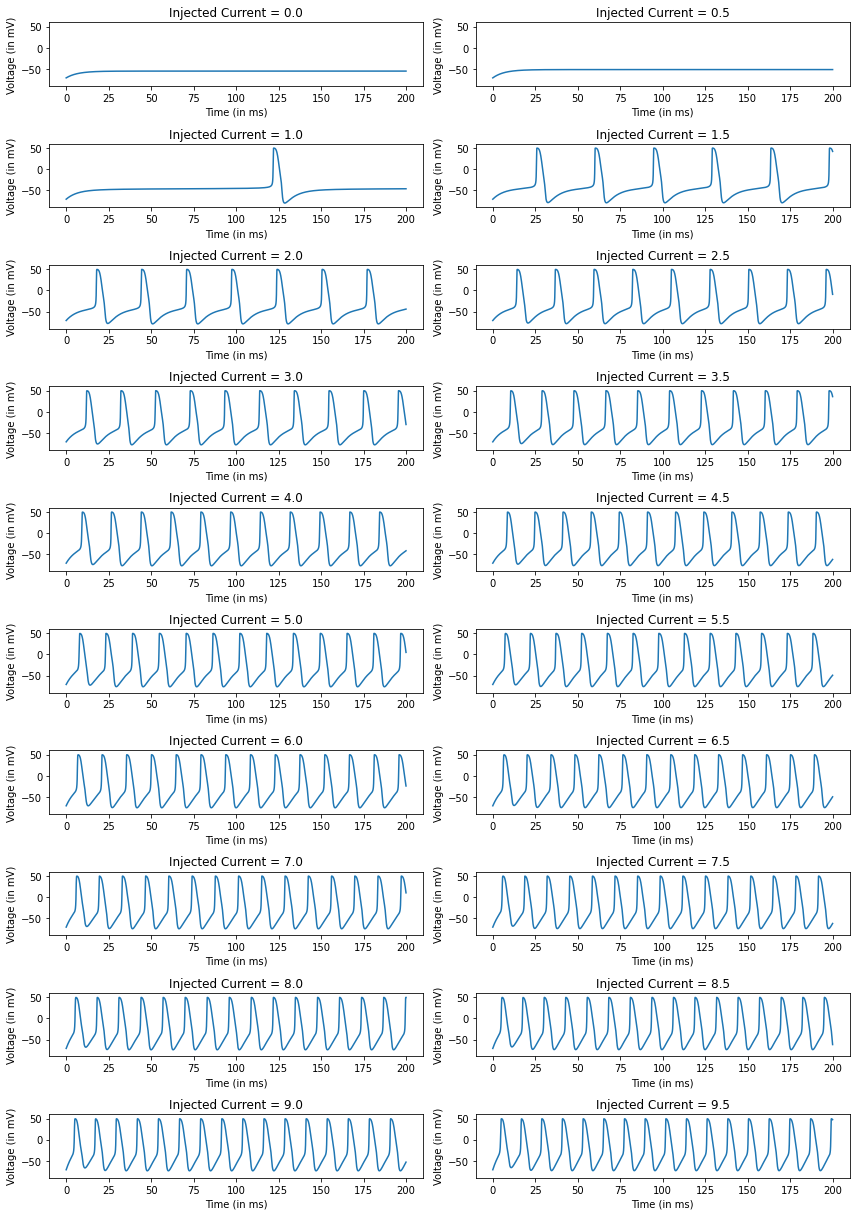

In [9]:
# Plot the membrane potentials

plt.figure(figsize=(12,17))
for i in range(20):
    plt.subplot(10,2,i+1)
    plt.plot(t,state[:,i])
    plt.title("Injected Current = {:0.1f}".format(i/2))
    plt.ylim([-90,60])
    plt.xlabel("Time (in ms)")
    plt.ylabel("Voltage (in mV)")
plt.tight_layout()
plt.show()

#### Quantifying the Firing Rates against Input Current

The firing frequency as a function of the input is shown in the figure below. The code to generate the firing rate is below.

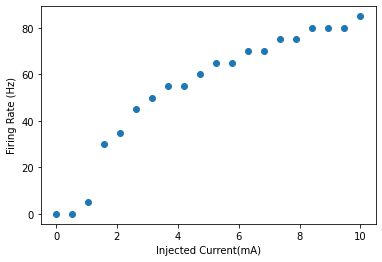

In [10]:
# Calculate the Firing Rates by counting the number of times the membrane potential crosses the threshold of 0mV for each neuron and dividing by the total time in seconds
fr = np.bitwise_and(state[:-1,:20]<0,state[1:,:20]>0).sum(axis=0)/0.2

# Plot the Firing Rates
plt.plot(np.linspace(0,10,20),fr,"o")
plt.xlabel("Injected Current(mA)")
plt.ylabel("Firing Rate (Hz)")
plt.show()

Now that we have simulated multiple independent systems of differential equations in a high efficient "vectorized" form, we can extend the ideas to more realistic networks consisting of neurons that interact with each other through non-linear connections in the form of excitatory and inhibitory synapses.

# References

(<a id="cit-Dayan2005" href="#call-Dayan2005">Dayan and Abbott, 2005</a>) Peter Dayan and Larry F. Abbott, ``Theoretical Neuroscience - Computational and Mathematical Modeling of Neural Systems``,  2005.

(<a id="cit-Johnston1995" href="#call-Johnston1995">Johnston and Wu, 1995</a>) D. Johnston and S. M.S. Wu, ``Foundations of cellular neurophysiology``,  1995.

(<a id="cit-Huxley1952" href="#call-Huxley1952">Huxley and Hodgkin, 1952</a>) Huxley A. L. and Hodgkin A. F., ``Quantitative description of nerve current``, Journal of Physiology, vol. , number , pp. ,  1952.

(<a id="cit-gerstnerMOOC" href="#call-gerstnerMOOC">MOOC</a>) , ``Neuronal dynamics``,  .  [online](https://www.edx.org/course/neuronal-dynamics)

(<a id="cit-compneuroMOOC" href="#call-compneuroMOOC">MOOC</a>) , ``Computational Neuroscience``,  .  [online](https://www.coursera.org/learn/computational-neuroscience)

(<a id="cit-Gerstner2014" href="#call-Gerstner2014">Gerstner, Kistler <em>et al.</em>, 2014</a>) Wulfram Gerstner, Werner M. Kistler, Richard Naud <em>et al.</em>, ``Neuronal dynamics: From single neurons to networks and models of cognition``,  2014.

